
# Cauchy tvAR(2) process
###### Author: Mokhtar Z. Alaya <alayaelm@utc.fr>
###### Ref: J. R. Statist. Soc. B (2017) 79, Part 5, pp. 1619–1643, "Quantile spectral analysis for locally stationary time series"

# Plot process

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import torch

from tensordict import TensorDict

import platform
if platform.system() == 'Darwin':
    device = torch.device("mps")
elif platform.system() == 'Linux':
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

import matplotlib.pyplot as plt
%matplotlib inline

params = {'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (10, 8)}
plt.rcParams.update(params)
import seaborn as sns

from src.torch.utils import *
from src.torch.utils import ECDFTorch
from src.torch.kernels import Kernel

from scipy.stats import wasserstein_distance

path_fig = '../figs'
process = 'CauchytvAR(2)'

# Choose kerl type fitting
space_kernel = "silverman" 
time_kernel = "tricube"
L = 1000 # n_replications
ttest = True

device = torch.device("cpu")

# 1 Conditional Mean Function $m^\star(u, x)$



\begin{equation*}
X_{t,T} = 1.8 \cos\big(1.5 - \cos(2\pi t/T)\big)X_{t-1, T} - 0.8 X_{t-2, T} + \varepsilon_{t,T}
\end{equation*}
and IID Cauchy noise $\varepsilon_{t,T}$




In [2]:
phi_star = lambda u: 1.5 - torch.cos(2 * torch.pi * torch.tensor([u])) 
psi_star = lambda u: 1.8
sigma_star = lambda u: 1.0

# Generate m_star
m_star = lambda u, x, y: psi_star(u) * torch.cos(phi_star(u)) * x - 0.8 * y

In [3]:
T_samples = 1000
# Create a mesh grid for u and x
u = torch.linspace(0., 1., T_samples)
x = torch.linspace(-5, 5, T_samples)

# Compute m_star values for plotting
m_star_vals = torch.tensor([m_star(u_val, x_val, x_val) for u_val, x_val in zip(u, x)]).to(device)

In [4]:
u = u.detach().cpu().numpy()
x = x.detach().cpu().numpy()
m_star_vals = m_star_vals.detach().cpu().numpy()


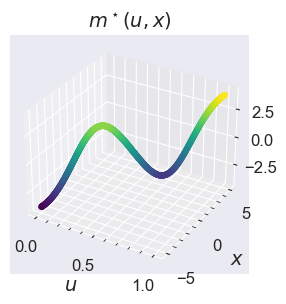

In [5]:

# Plot of m^star V1
plt.rcParams['text.usetex'] = False
plt.rcParams["figure.figsize"] = (10,3)
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.minorticks_on()
ax.scatter(u, x, m_star_vals, c=m_star_vals, cmap='viridis', linewidth=0.1);
ax.set_xlabel(r'$u$', fontsize=14)
ax.set_ylabel(r'$x$', fontsize=14)
ax.set_title(r'$m^\star(u,x)$', fontsize=14)
figure_name_mean_function = f"Conditional_mean_function_of_process_{process}.png"
plt.tight_layout() 
fig.savefig(os.path.join(path_fig, figure_name_mean_function ), dpi=150)
plt.show()

# 2 Generate $L$ replications of the process

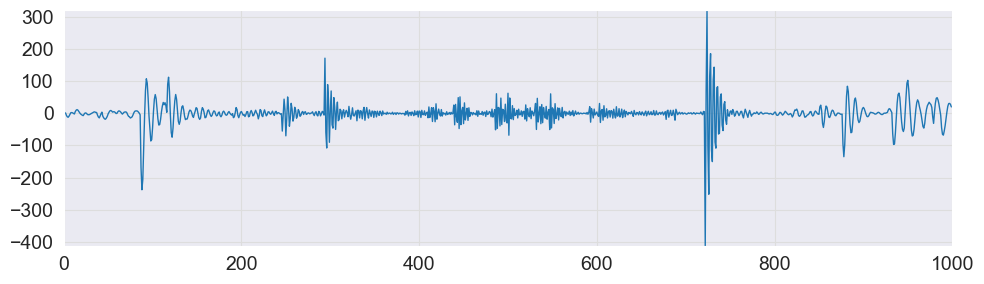

In [6]:
n_replications = 1
d = 2

X_tvar_2 = torch.zeros(T_samples).to(device)
X_tvar_2_replications = torch.zeros((n_replications, T_samples)).to(device)

X_dict = {}

cauchy_distrib = torch.distributions.cauchy.Cauchy(loc=0., scale=1.)

for replication in range(n_replications):
    t = 2
    epsilon = cauchy_distrib.sample(sample_shape=(T_samples,)).to(device)
    X = torch.zeros((T_samples,d)).to(device)
    while t <= T_samples-1 :
        m_star_val = m_star(t/T_samples, X_tvar_2[t-1].to(device='cpu'), X_tvar_2[t-2].to(device='cpu'))
        X_tvar_2[t] = m_star_val.to(device) + sigma_star(t/T_samples) * epsilon[t]
        X[t] = torch.tensor([X_tvar_2[t-1], X_tvar_2[t-2]])
        t += 1
        
    X_dict[str(replication)] = X
    X_tvar_2_replications[replication] = X_tvar_2
    
fig = plt.figure(figsize=(10,3)) 

for replication in range(n_replications):
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.minorticks_on()
    plt.plot(X_tvar_2_replications[replication].detach().cpu().numpy(), lw=1)
    plt.xlim(0, T_samples)
    plt.ylim(min(X_tvar_2_replications[replication].detach().cpu().numpy()) , max(X_tvar_2_replications[replication].detach().cpu().numpy()))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

figure_name_process = f"Simulation_of_{process}_with_Time_Samples_{T_samples}.png"
plt.tight_layout() 
fig.savefig(os.path.join(path_fig, figure_name_process), dpi=150)
plt.show()

# Conditional mean NW estimator 

# Kernel fit
lambda_ = 1/12
bandwidth = lambda_ * T_samples **(-0.4 / (d+1))

GaussUnifKernel = Kernel(T=T_samples, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 

# Weights
weights = {}
for t in range(T_samples):
    weights[str(t)] = GaussUnifKernel.fit(X_dict['0'], t)

Y_t_T = X_tvar_2_replications[0]

m_hat = torch.tensor([torch.sum(weights[str(t)] * Y_t_T) for t in range(T_samples)])

m_hat = m_hat.detach().cpu().numpy()
Y_t_T = Y_t_T.detach().cpu().numpy()

plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T_samples)

plt.plot(Y_t_T, lw=1, label="LSP")
plt.plot(m_hat, lw=1, label="Conditional mean function")
# plt.plot(X_tvar_2_replications_u_var[replication], lw=2)
# plt.plot(X_tvar_2_mean)
# plt.xticks(np.arange(0, T+1, 200, dtype=int))
plt.xlim(0, T_samples)
# plt.title(r'$Y_{t,T} = m^\star(\frac{t}{T}, X_{t,T}) + \varepsilon_{t,T}$')
plt.legend()
plt.tight_layout()
#plt.savefig(path_fig+"locally_process_conditional_mean_Guassina_space_kernel_uniform_tiem_kernel.pdf", dpi=150)
plt.show()

# 3 NW estimator

In [7]:
d = 2
if ttest is not None:
    times_T = torch.tensor([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]).to(device)
    times_t = torch.tensor([150, 200, 250, 300, 350, 400, 450, 500]).to(device) 
    n_replications = L
else:
    times_T = torch.tensor([5, 10]).to(device)
    times_t = torch.tensor([1, 3]).to(device) 
    n_replications = 2

In [8]:
X_tvar_2_replications = TensorDict(
    {f"T:{T}":torch.zeros((n_replications, T)) for T in times_T},
    device=device
)
X_dict = TensorDict(
    {f"T:{T}":TensorDict({}, device=device) for T in times_T}
)

In [9]:
def simulation_1_rep_process(T):
    t = 2
    epsilon = torch.normal(mean=0., std=1., size=(T,)).to(device)
    X = torch.zeros((T,d)).to(device)
    X_tvar_2_T = torch.zeros(T).to(device)
    while t <= T-1 :
        m_star_val = m_star(t/T_samples, X_tvar_2_T[t-1].to(device='cpu'), X_tvar_2_T[t-2].to(device='cpu'))
        X_tvar_2_T[t] = m_star_val.to(device) + sigma_star(t/T_samples) * epsilon[t]
        X[t] = torch.tensor([X_tvar_2_T[t-1], X_tvar_2_T[t-2]])

        t += 1
            
    return X_tvar_2_T, X


for T in times_T:
    for replication in range(n_replications):
        X_tvar_2_T, X = simulation_1_rep_process(T)
        X_tvar_2_replications[f"T:{T}"][replication] = X_tvar_2_T
        X_dict[f"T:{T}"][str(replication)] = X

In [10]:
X_tvar_2 = TensorDict(
    {f"t:{t}_T:{T}":torch.empty(n_replications, dtype=torch.float) for t in times_t for T in times_T},
     device=device
)

for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = torch.tensor([X_tvar_2_replications[f"T:{T}"][replication][t-1] for replication in range(n_replications)])

# ECDFTorch

In [11]:
plt.rcParams["figure.figsize"] = (5,4)

norm_X_tvar_2 = {}

for t in times_t:
    for T in times_T:
        ecdf = ECDFTorch(X_tvar_2[f"t:{t}_T:{T}"])
        probabilities = ecdf.y
        samples = ecdf.x
        norm_X_tvar_2[f"t:{t}_T:{T}"] = torch.tensor(probabilities)

        # sns.lineplot(
            # x=samples, y=probabilities, lw=2, markers=True,
            # label=f"(t,T)={t, T}",  
            # drawstyle='steps-mid',          
        # )
        # plt.legend()
        # plt.tight_layout()
        # plt.show()

In [12]:
# norm_X_tvar_2.keys() # dict_keys(['t:1_T:5', 't:1_T:10', 't:2_T:5', 't:2_T:10', 't:3_T:5', 't:3_T:10'])


# 4 Nadara-Watson estimator: Uniform kernel for time and Gaussian kernel space directions


## 4.1 Weights computation

\begin{align}
  \omega_{a}(\frac t T, \boldsymbol{x})=\frac{\displaystyle  K_{h,1}(\frac{t}{T} - \frac{a}{T})\prod_{j=1}^dK_{h,2}(x^j- X_{a,T}^j)}{\displaystyle \sum_{a=1}^TK_{h,1}(\frac{t}{T} - \frac{a}{T})\prod_{j=1}^dK_{h,2}(x^j - X_{a,T}^j)}.
 \end{align}

In [13]:
# Creation of the kernels
xi = 0.4 / (2*(d+1))
lambda_ = 1/12
bandwidth = lambda_ * T**(-xi)

In [14]:
gaussian_kernel = TensorDict(
    { f"T:{T}":Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel, device=device) for T in times_T},
        device=device,
)

In [15]:
gaussian_weights = TensorDict(
    {f"t:{t}_T:{T}":TensorDict({}, device=device) for t in times_t for T in times_T}
)

In [ ]:
print("Fitting gaussian kernel and unifom time kernel")
tic = time.time()
for t in times_t:
    for T in times_T:
        gaussian_weights[f"t:{t}_T:{T}"] = {str(replication):gaussian_kernel[f"T:{T}"].fit(X_dict[f"T:{T}"][str(replication)], t-1) for replication in range(n_replications)}

tac = time.time()
toc = tac - tic
print(f"Time taken for kernel fitting = {toc} seconds")

Fitting gaussian kernel and unifom time kernel


In [ ]:
gaussian_weights_tensor = TensorDict(
    {
        f"t:{times_t[t]}_T:{times_T[T]}":TensorDict({
            str(replication):gaussian_weights[f"t:{times_t[t]}_T:{times_T[T]}"][str(replication)] for replication in range(n_replications)
        }, 
        device=device) 
        for t in range(len(times_t)) for T in range(len(times_T))
    },
    device=device,
)
            

## 4.2 Empirical CDF   $ \displaystyle F_t^L(y|\boldsymbol{x}) = \frac{1}{L} \sum_{l=1}^L \mathds{1}_{Y_{t,T}^{(l)}\leq y}$.

In [ ]:

empirical_cds = TensorDict(
    {
        f"t:{t}_T:{T}":ECDFTorch(X_tvar_2[f"t:{t}_T:{T}"]).y for t in times_t for T in times_T
    },
    device=device,
)


# 4.3  $l$-th NW estimator 

For each $l \in \{1, \ldots, L\}$, calculate NW conditional CDF
    
$$\hspace{5cm}  \displaystyle \hat{F}_{t}^{(l)}(y|\boldsymbol{x})=\sum_{a=1}^T \omega_{a}(\frac tT,\boldsymbol{x})  \mathds{1}_{Y_{a,T}^{(l)}\leq y}
$$

In [ ]:
times_t = times_t.detach().cpu().numpy()
times_T = times_T.detach().cpu().numpy()

In [ ]:
pplot = None

x_rep = TensorDict(
    {
        f"t:{t}_T:{T}":torch.zeros((n_replications, T+1)) for t in times_t for T in times_T
    },
    device=device,
)

y_rep = TensorDict(
    {
        f"t:{t}_T:{T}":torch.zeros((n_replications, T+1)) for t in times_t for T in times_T
    },
    device=device,
)

wasserstein_distances = TensorDict(
    {
        f"t:{t}_T:{T}":TensorDict({}) for t in times_t for T in times_T
    },
    device='cpu',
)


for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = torch.zeros((n_replications, T+1))
        y_rep[f"t:{t}_T:{str(T)}"] = torch.zeros((n_replications, T+1))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications): 
    for t in times_t:
        for T in times_T:
            
            weighted_ecdf = ECDFTorch(X_tvar_2_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{T}"][str(replication)])

            x_rep[f"t:{t}_T:{str(T)}"][replication] = weighted_ecdf.x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = weighted_ecdf.y
                        
            ecdf = ECDFTorch(X_tvar_2_replications[f"T:{T}"][replication])

            weighted_ecdf_y = ecdf.y.detach().cpu().numpy()
            ecdf_y = ecdf.y.detach().cpu().numpy()
            distance = wasserstein_distance(weighted_ecdf_y, ecdf_y)
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
            
            if pplot is not None:
                x = x_rep[f"t:{t}_T:{str(T)}"][replication]
                x= x.detach().cpu().numpy()
                y = y_rep[f"t:{t}_T:{str(T)}"][replication]
                y = y.detach().cpu().numpy()
                plt.plot(x, y, label=f"t:{t}_T:{T}")# _replication:{replication}")
                plt.xlabel(r'$y$')
                plt.ylabel(r'$\hat{F}_t(y|x)$')
                ## plt.xticks(np.arange(0, T+1, 200, dtype=int))
                ##plt.xlim(-18, 18)
                plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
                plt.legend()
                plt.tight_layout()
            if pplot is not None:
                plt.show()
            ##plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)

            

In [ ]:
wass_distances_all_replications = {}

for t in times_t:
    for T in times_T:
        wass_distances_all_replications[f"t:{t}_T:{T}"] = []

for t in times_t:
    for T in times_T:       
        for replications in range(n_replications):
            wass_distances_all_replications[f"t:{t}_T:{T}"].append(wasserstein_distances[f"t:{t}_T:{T}"][str(replication)])
        

# 5 $W_1(\hat{F}_t^L(y|\boldsymbol{x}),  F_t^L(y|\boldsymbol{x}) )$

In [ ]:
plt.rcParams["figure.figsize"] = (10,3)
wass_distances_empirical_meanNW = {}
for t in times_t:
    for T in times_T:
        emp_ccf = empirical_cds[f"t:{t}_T:{T}"].detach().cpu().numpy()
        emp_mean_nw = y_rep[f"t:{t}_T:{T}"].mean(axis=0).detach().cpu().numpy()
        wass_distances_empirical_meanNW[f"t:{t}_T:{T}"] = wasserstein_distance(emp_ccf, emp_mean_nw)

In [ ]:
plt.rcParams["figure.figsize"] = (10,3)
wass_times_t = {}

for t in times_t:
    wass_times_t[f"t:{t}"] = []

for t in times_t:
    for T in times_T:
        wass_times_t[f"t:{t}"].append(wass_distances_empirical_meanNW[f"t:{t}_T:{T}"])

In [ ]:
figure_name = f"torch_wassdistance_{process}_TimeKernel{time_kernel}_SpaceKernel{space_kernel}_L={n_replications}.png"

fig = plt.figure(figsize=(8,4))
colors = plt.cm.Set1(np.linspace(0, .5, 8))
markers = ['o', '>', 'D', 'X', "p", 's', 'P', '*'] 
for i, t in zip(range(len(times_t)), times_t):
    plt.plot(times_T, wass_times_t[f"t:{t}"], label=f"t:{t}", color=colors[i], marker=markers[i], markersize=6, lw=2)
    plt.xlim(times_T.min(), times_T.max())
    plt.xlabel(r'Sample size ${T}$ ')
    plt.ylabel("Wasserstein distance")
    plt.legend()
    plt.grid(True)

plt.tight_layout() 
plt.show()
fig.savefig(os.path.join(path_fig, figure_name), dpi=150)